<a href="https://colab.research.google.com/github/FoleyLab/FoleyLab.github.io/blob/master/notebooks/Wavepacket_animations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time evolution of a Gaussian wavepacket
[Prof. Jay Foley, University of North Carolina Charlotte](https://foleylab.github.io/)

#### Objectives
- To demonstrate the expansion of a Gaussian wavepacket as a superposition of particle-in-a-box energy eigenstates
- To demonstrate the time-dependence of a Gaussian wavepacket traveling between two infinitely tall potential walls
- To calculate the momentum uncertainty of the Gaussian wavepacket as a function of time

#### Learning Outcomes
By the end of this workbook, students should be able to
- Expand an arbitrary wavefunction in the energy eigenstate basis, and specifically apply this to the expansion of a Gaussian wavepacket in the basis of the particle-in-a-box energy eigenstates
- Utilize the `trapz` function of `numpy` to perform numeric integration
- Use the known time dependence of energy eigenstates of the particle-in-a-box to simulate the time evolution of the Gaussian wavepacket travelling between two infinitely tall ptential walls
- Use the capabilities of `matplotlib` to animate the motion of the Gaussian wavepacket
- Compute time-dependent expectation values of the Gaussian wavepacket, and specifically track the momentum uncertainty of this state as a function of time.

#### Summary
We will demonstrate the time-dependence of an electron initially described by a Gaussian wavepacket that is travelling between two infinitely tall potential walls located at $x=0$ and $x = L$.  The initial state of this wavepacket will be given by
\begin{equation}
\Psi(x,t_0) = \frac{1}{\sigma \sqrt(2\pi)} {\rm exp}\left(\frac{-1}{2}\left(\frac{x-x_0}{\sigma}\right)^2\right) {\rm exp}(i k_0 x). \tag{1}
\end{equation}
Such a wavefunction describes a particle initially with a mean momentum and position of $\hbar k_0$ and $x_0$, respectively, and $\sigma$ relates to the spread (or position uncertainty)
of the particle.  In the code that follows, we will have $x_0 = 200$, $k_0 = 0.4$, and $\sigma = 15$ atomic units.  We will specify that the location of the left-most infinite potential is at $L = 500$ atomic units.  We will use the fact that we can we can expand this wavefunction in any complete basis, and we will use the basis of the energy eigenfunctions of the particle in a box with $L = 500$ atomic units.  

Hence, we will expand the wavefunction as follows:
\begin{equation}
\Psi(x,t) = \sum_{n=1}^N c_n \sqrt{\frac{2}{L}} {\rm sin}\left( \frac{n \pi x}{L} \right)
{\rm exp}\left(-\frac{i E_n t}{\hbar}\right), \tag{2}
\end{equation}
where we have used the known time-dependence of each energy eigenstate.  The energy eigenvalues have the form
\begin{equation}
E_n = \frac{n^2 \pi^2 \hbar^2}{2 m L^2}. \tag{3}
\end{equation}
Since we are working in atomic units, $\hbar$ and $m$ will have the value of 1.

The coefficients for the above expansion can be determined simply by
\begin{equation}
c_n = \sqrt{\frac{2}{500}} \int_0^{500} {\rm sin}\left(\frac{n \pi x}{500}\right) \cdot \Psi(x,t_0) \: dx \tag{4}
\end{equation}
where we have set $L = 500$.  We will use the `numpy` function `trapz(fx, x)` to perform a trapezoid rule approximation to 
this integral.

### Step 0:  Import libraries and initialize a plot object for the animation

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for the gaussian wavepacket and the PIB functions
x0 = 200
sig = 15
k0 = 0.4
L = 500

### grid of x values for the functions
x = np.linspace(0,500,500)

### parameters for plot
ax.set_xlim((0, L))
ax.set_ylim((-0.03, 0.03))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

#### Step 1: Define helper functions that will compute the PIB basis functions and energy eigenvalues
It will be helpful to have helper functions that will evaluate the energy eigenfunctions and eigenvalues of the 
particle in a box given the quantum number $n$, the length of the box $L$, and the grid of $x$ values for the eigenfunction.

In [24]:
def energy_eigenvalue(n, L):
    """ Helper function to take the quantum number n of the particle in a box and the length 
        of the box L and return the energy eigenvalue in atomic units.  This assumes the mass of the particle
        is 1 in atomic units (i.e. it assumes the particle is an electron).
        The length should be in atomic units.
        
    Arguments
    ---------
    n : int
        the quantum state of the particle in a box
        
    L : float
        the length of the box in atomic units
    """
    m = 1 
    return n ** 2 * np.pi ** 2 / ( 2 * m * L ** 2)

def energy_eigenfunction_phase(n, L, t):
    """ Helper function to take the quantum number n of the particle in a box and the length 
        of the box L, and the time value and return the time-dependent phase. This assumes the mass of the particle
        is 1 in atomic units (i.e. it assumes the particle is an electron).
        The length and time should be in atomic units.
        
    Arguments
    ---------
    n : int
        the quantum state of the particle in a box
        
    L : float
        the length of the box in atomic units
        
    t : float
        the time in atomic units
    """
    ci = 0+1j
    En = energy_eigenvalue(n, L)
    return np.exp(-ci * En * t)
    

def energy_eigenfunction(n, L, x):
    """ Helper function to take the quantum number n of the particle in a box, the length 
        of the box L, and x-coordinate value(s) (single value or list) and return the corresponding
        energy eigenstate value(s) of the ordinary particle in a box.  L and x should be in atomic units,
        and the maximum value of x should be L.
        
    Arguments
    ---------
    n : int
        the quantum state of the particle in a box      
    L : float
        the length of the box in atomic units
    x : float (or numpy array of floats)
        the position variable for the energy eigenstate in atomic units
    """
    return np.sqrt(2 / L) * np.sin(n * np.pi * x / L)

#### Step 2: Define a helper function that will compute values of the Gaussian wavepacket 
We will define a function to take the $\sigma$, $x_0$, and $k_0$ parameters and $x$ value(s) that define Eq. (1) and return $\Psi(x,t_0)$.

In [25]:
def gaussian_wavepacket(x0, sig, k0, x):
    """ Helper function to take the the spread (sig), mean wavenumber (k0), mean position value (x0) 
        and grid of x-values (x) and return the corresponding Gaussian wavepacket values evaluated on that grid
        
    Arguments
    ---------
    x0 : float
        mean position of the wavepacket in atomic units    
    sig : float
        spread of the wavepacket in atomic units
    k0  : float
        the mean wavenumber in atomic units of the wavepacket, related to
        mean momentum by \hbar k0
    x : float (or numpy array of floats)
        the position variable for the energy eigenstate in atomic units
    """
    ci = 0+1j # <== the imaginary unit
    pre = 1 / (sig * np.sqrt(2 * np.pi)) # <== prefactor
    gauss = np.exp(-0.5 * ((x - x0) / sig) ** 2) # <== gaussian envelope
    plane = np.exp(ci * k0 * x) # <== plane-wave component
    return pre * gauss * plane
    

#### Step 3: Set up plot and function parameters and form the Gaussian Wavepacket at time t=t0

/opt/anaconda3/envs/wpspec/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


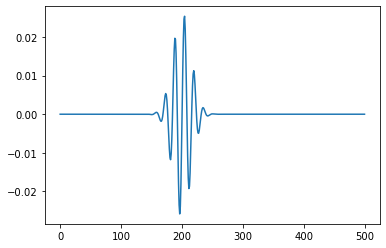

In [26]:
### Compute the Gaussian wavepacket
psi_gp = gaussian_wavepacket(x0, sig, k0, x)
plt.plot(x, psi_gp)

##### Step 3:  Determine the expansion coefficients for the Gaussian Wavepacket in the PIB basis

In [27]:
### Create an array of quantum numbers for the PIB states... 1 to 100 should be adequate
n_array = np.linspace(1,100,100, dtype=int)
### Each quantum number n has a corresponding (complex) coefficient c_n 
cn_array = np.zeros(len(n_array),dtype=complex)

for i in range(0,100):
    ### multiply psi_n by gaussian wavepacket
    integrand = np.conj(energy_eigenfunction(n_array[i], L, x) ) * psi_gp
    ### get coefficient c_n from the integral of psi_n * Psi_gp
    cn_array[i] = np.trapz(integrand, x)




#### Step 4: Put it all together and animate!

In [28]:
N_time = 300


y = np.zeros(len(x),dtype=complex)
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    y = np.zeros(len(x),dtype=complex)
    for j in range(0,100):
        ft = energy_eigenfunction_phase(n_array[j], L, i * 10)
        fx = energy_eigenfunction(n_array[j], L, x)
        y = y + cn_array[j] * fx * ft
    t[i] = i*10
    line.set_data(x, np.real(y))
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

# Reference Link
http://tiao.io/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/